In [7]:
import os
import nest_asyncio
from typing_extensions import TypedDict
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langfuse import get_client
from langfuse.langchain import CallbackHandler
from langchain_core.runnables.graph import (CurveStyle, MermaidDrawMethod, NodeStyles)


In [ ]:
# Environment configuration
LANGFUSE_PUBLIC_KEY = os.getenv("LANGFUSE_PUBLIC_KEY")
LANGFUSE_SECRET_KEY = os.getenv("LANGFUSE_SECRET_KEY")
LANGFUSE_HOST = os.getenv("LANGFUSE_HOST")  


OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

langfuse = get_client()
langfuse_handler = CallbackHandler()


# LLM
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)

In [9]:
# State
class State(TypedDict):
    input_file_path: str
    file_content: str
    medical_entities: str
    layman_summary: str
    recommendations: str

# Nodes
def extract_text(state: State):
    """
    Assumes input_file_path already contains extracted text.
    (OCR / Vision should happen upstream)
    """
    prompt = (
        "You are a skilled medical AI assistant. Extract structured data from this diagnostic report.\n\n"
        "Return ONLY a valid JSON object with key medical parameters like vitals, lab values, and diagnoses.\n"
        "Do not include any explanations, markdown, or extra text.\n\n"
        f"Report content:\n{state['input_file_path']}"
    )

    result = llm.invoke(
        prompt,
        config={"callbacks": [langfuse_handler]}
    )

    return {"file_content": result.content.strip()}


def extract_entities(state: State):
    prompt = (
        "Extract important medical entities from this structured report content. "
        "Focus on vitals, lab values, conditions, and abnormalities.\n\n"
        f"{state['file_content']}"
    )

    result = llm.invoke(
        prompt,
        config={"callbacks": [langfuse_handler]}
    )

    return {"medical_entities": result.content.strip()}


def summarize_layman(state: State):
    prompt = (
        "Explain the following medical findings in simple terms for a non-medical person:\n\n"
        f"{state['medical_entities']}"
    )

    result = llm.invoke(
        prompt,
        config={"callbacks": [langfuse_handler]}
    )

    return {"layman_summary": result.content.strip()}


def recommend_lifestyle(state: State):
    prompt = (
        "Based on these simplified findings, suggest appropriate and practical lifestyle changes.\n\n"
        f"{state['layman_summary']}"
    )

    result = llm.invoke(
        prompt,
        config={"callbacks": [langfuse_handler]}
    )

    return {"recommendations": result.content.strip()}

In [10]:
# Workflow
workflow = StateGraph(State)

workflow.add_node("extract_text", extract_text)
workflow.add_node("extract_entities", extract_entities)
workflow.add_node("summarize_layman", summarize_layman)
workflow.add_node("recommend_lifestyle", recommend_lifestyle)

workflow.add_edge(START, "extract_text")
workflow.add_edge("extract_text", "extract_entities")
workflow.add_edge("extract_entities", "summarize_layman")
workflow.add_edge("summarize_layman", "recommend_lifestyle")
workflow.add_edge("recommend_lifestyle", END)

chain = workflow.compile()

In [11]:
# Run
state = chain.invoke(
    {
        # IMPORTANT:
        # This should be extracted medical TEXT, not an image path
        "input_file_path": "Patient has elevated ALT and AST levels..."
    },
    config={"callbacks": [langfuse_handler]}
)

print("Extracted Content:\n", state["file_content"])
print("\nEntities:\n", state["medical_entities"])
print("\nSummary:\n", state["layman_summary"])
print("\nRecommendations:\n", state["recommendations"])


Extracted Content:
 {
  "vitals": {},
  "lab_values": {
    "ALT": "elevated",
    "AST": "elevated"
  },
  "diagnoses": []
}

Entities:
 Based on the provided structured report content, the important medical entities extracted are:

- **Lab Values:**
  - ALT: elevated
  - AST: elevated

- **Conditions/Abnormalities:**
  - Elevated liver enzymes (indicated by elevated ALT and AST)

- **Vitals:**
  - No vital signs provided.

- **Diagnoses:**
  - No diagnoses listed. 

This summary highlights the key lab values and abnormalities present in the report.

Summary:
 Sure! Here’s a simple explanation of the medical findings:

1. **Lab Values:**
   - **ALT and AST:** These are two types of enzymes found in the liver. In this report, both ALT and AST levels are higher than normal. This is often a sign that something might be affecting the liver.

2. **Conditions/Abnormalities:**
   - **Elevated liver enzymes:** When the levels of ALT and AST are high, it usually means that the liver is under s

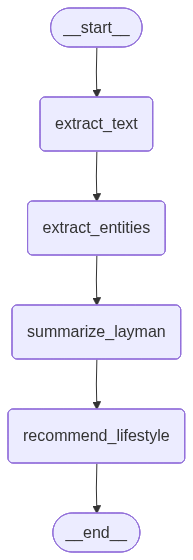

In [12]:
# Graph Visualization
nest_asyncio.apply()

display(
    Image(
        chain.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(
                first="#ffdfba",
                last="#baffc9",
                default="#fad7de"
            ),
            wrap_label_n_words=9,
            draw_method=MermaidDrawMethod.API,
            background_color="white",
            padding=10
        )
    )
)